In [111]:
import casadi as ca
import numpy as np
import sys
import control

sys.path.insert(0, '../python/pyecca')

import matplotlib.pyplot as plt
import pyecca.lie.so3 as so3
from pyecca.util import rk4

def u_to_fin(u):
    ail = u[1]
    elv = u[2]
    rdr = u[3]
    # top, left, down right
    return ca.vertcat(ail - rdr, ail - elv, ail + rdr, ail + elv)
 

def rocket_equations(jit=True):
    x = ca.SX.sym('x', 14)
    u = ca.SX.sym('u', 4)
    p = ca.SX.sym('p', 16)
    t = ca.SX.sym('t')
    dt = ca.SX.sym('dt')

    # State: x
    # body frame: Forward, Right, Down
    omega_b = x[0:3]  # inertial angular velocity expressed in body frame
    r_nb = x[3:7]  # modified rodrigues parameters
    v_b = x[7:10]  # inertial velocity expressed in body components
    p_n = x[10:13]  # positon in nav frame
    m_fuel = x[13]  # mass
    
    # Input: u
    m_dot = ca.if_else(m_fuel > 0, u[0], 0)
    fin = u_to_fin(u)
    
    # Parameters: p
    g = p[0]  # gravity
    Jx = p[1]  # moment of inertia
    Jy = p[2]
    Jz = p[3]
    Jxz = p[4]
    ve = p[5]
    l_fin = p[6]
    w_fin = p[7]
    CL_alpha = p[8]
    CL0 = p[9]
    CD0 = p[10]
    K = p[11]
    s_fin = p[12]
    rho = p[13]
    m_empty = p[14]
    l_motor = p[15]
    
    # Calculations
    m = m_empty + m_fuel
    J_b = ca.SX.zeros(3, 3)
    J_b[0, 0] = Jx + m_fuel*l_motor**2
    J_b[1, 1] = Jy + m_fuel*l_motor**2
    J_b[2, 2] = Jz
    J_b[0, 2] = J_b[2, 0] = Jxz

    C_nb = so3.Dcm.from_mrp(r_nb)
    g_n = ca.vertcat(0, 0, g)
    v_n = ca.mtimes(C_nb, v_b)
    
    # aerodynamics
    VT = ca.norm_2(v_b)
    q = 0.5*rho*ca.dot(v_b, v_b)
    fins = {
        'top': {
            'fwd': [1, 0, 0],
            'up': [0, 1, 0],
            'angle': fin[0]
        },
        'left': {
            'fwd': [1, 0, 0],
            'up': [0, 0, -1],
            'angle': fin[1]
        },
        'down': {
            'fwd': [1, 0, 0],
            'up': [0, -1, 0],
            'angle': fin[2]
        },
        'right': {
            'fwd': [1, 0, 0],
            'up': [0, 0, 1],
            'angle': fin[3]
        },
    }
    rel_wind_dir = v_b/VT

    # build fin lift/drag forces
    vel_tol = 1e-3
    FA_b = ca.vertcat(0, 0, 0)
    MA_b = ca.vertcat(0, 0, 0)
    for key, data in fins.items():
        fwd = data['fwd']
        up = data['up']
        angle = data['angle']
        U = ca.dot(fwd, v_b)
        W = ca.dot(up, v_b)
        side = ca.cross(fwd, up)
        alpha = ca.if_else(ca.fabs(U) > vel_tol, -ca.atan(W/U), 0)
        perp_wind_dir = ca.cross(side, rel_wind_dir)
        norm_perp = ca.norm_2(perp_wind_dir)
        perp_wind_dir = ca.if_else(ca.fabs(norm_perp) > vel_tol, 
            perp_wind_dir/norm_perp, up)
        CL = CL0 + CL_alpha*(alpha + angle)
        CD = CD0 + K*(CL - CL0)**2
        # model stall as no lift if above 23 deg.
        L = ca.if_else(ca.fabs(alpha)<0.4, CL*q*s_fin, 0)
        D = CD*q*s_fin
        FAi_b = L*perp_wind_dir - D*rel_wind_dir
        FA_b += FAi_b
        MA_b += ca.cross(-l_fin*fwd - w_fin*side, FAi_b)

    FA_b = ca.if_else(ca.fabs(VT) > vel_tol, FA_b, ca.SX.zeros(3))
    MA_b = ca.if_else(ca.fabs(VT) > vel_tol, MA_b, ca.SX.zeros(3))

    # propulsion
    FP_b = ca.vertcat(m_dot*ve, 0, 0)
    
    # force and momental total
    F_b = FA_b + FP_b + ca.mtimes(C_nb.T, m*g_n)
    M_b = MA_b

    force_moment = ca.Function(
        'force_moment', [x, u, p], [F_b, M_b], ['x', 'u', 'p'], ['F_b', 'M_b'])
    
    
    # right hand side
    rhs = ca.Function('rhs', [x, u, p], [ca.vertcat(
        ca.mtimes(ca.inv(J_b), M_b - ca.cross(omega_b, ca.mtimes(J_b, omega_b))),
        so3.Mrp.kinematics(r_nb, omega_b),
        F_b/m - ca.cross(omega_b, v_b),
        ca.mtimes(C_nb, v_b), -m_dot)], ['x', 'u', 'p'], ['rhs'], {'jit': jit})

    # prediction
    t0 = ca.SX.sym('t0')
    h = ca.SX.sym('h')
    x0 = ca.SX.sym('x', 14)
    x1 = rk4(lambda t, x: rhs(x, u, p), t0, x0, h)
    x1[3:7] = so3.Mrp.shadow_if_necessary(x1[3:7])
    euler1 = so3.Euler.from_mrp(x1[3:7])
    predict = ca.Function('predict', [x0, u, p, t0, h], [x1,euler1], {'jit': jit})

    def schedule(t, start, ty_pairs):
        val = start
        for ti, yi in ty_pairs:
            val = ca.if_else(t > ti, yi, val)
        return val

    # reference trajectory
    pitch_d = 1.0

    euler = so3.Euler.from_mrp(r_nb) # roll, pitch, yaw
    pitch = euler[1]
    
    # control
    u_control = ca.SX.zeros(4)
    # these controls are just test controls to make sure the fins are working
    u_control[0] = 0.1  # mass flow rate
    u_control[1] = 0
    u_control[2] = (pitch - 1)
    u_control[3] = 0
    control = ca.Function('control', [x, p, t, dt], [u_control],
        ['x', 'p', 't', 'dt'], ['u'])

    # initialize
    pitch_deg = ca.SX.sym('pitch_deg')
    omega0_b = ca.vertcat(0, 0, 0)
    r0_nb = so3.Mrp.from_euler(ca.vertcat(0, pitch_deg*ca.pi/180, 0))
    v0_b = ca.vertcat(0, 0, 0)
    p0_n = ca.vertcat(0, 0, 0)
    m0_fuel = 0.8
    # x: omega_b, r_nb, v_b, p_n, m_fuel
    x0 = ca.vertcat(omega0_b, r0_nb, v0_b, p0_n, m0_fuel)
    #     g, Jx, Jy, Jz, Jxz, ve, l_fin, w_fin, CL_alpha, CL0, CD0, K, s, rho, m_emptpy, l_motor
    p0 = [9.8, 0.05, 1.0, 1.0, 0.0, 350, 1.0, 0.05, 2*np.pi, 0, 0.01, 0.01, 0.05, 1.225, 0.2, 1.0]
    initialize = ca.Function('initialize', [pitch_deg], [x0, p0,pitch_deg])

    return {
        'rhs': rhs,
        'predict': predict,
        'control': control,
        'initialize': initialize,
        'force_moment': force_moment,
        'x': x,
        'u': u,
        'p': p
    }

def analyze_data(data):
    plt.figure(figsize=(20, 20))
    plt.subplot(331)
    plt.title('fuel')
    plt.plot(data['t'], data['x'][:, 13])
    plt.xlabel('t, sec')
    plt.ylabel('mass, kg')
    plt.grid()

    plt.subplot(332)
    #plt.title('velocity')
    plt.plot(data['t'], data['x'][:, 7], label='x')
    plt.plot(data['t'], data['x'][:, 8], label='y')
    plt.plot(data['t'], data['x'][:, 9], label='z')
    plt.xlabel('t, sec')
    plt.ylabel('body velocity, m/s')
    plt.grid()
    plt.legend()
    
    plt.subplot(333)
    euler = np.array(
        [np.array(ca.DM(so3.Euler.from_mrp(x))).reshape(-1) for x in data['x'][:, 3:7]])
    plt.plot(data['t'], np.rad2deg(euler[:, 0]), label='roll')
    plt.plot(data['t'], np.rad2deg(euler[:, 1]), label='pitch')
    plt.plot(data['t'], np.rad2deg(euler[:, 2]), label='yaw')
    plt.legend()
    plt.grid()
    plt.xlabel('t, sec')
    plt.ylabel('euler angles, deg')
    #plt.title('euler')
    
    plt.subplot(334)
    #plt.title('angular velocity')
    plt.plot(data['t'], data['x'][:, 0], label='x')
    plt.plot(data['t'], data['x'][:, 1], label='y')
    plt.plot(data['t'], data['x'][:, 2], label='z')
    plt.xlabel('t, sec')
    plt.ylabel('angular velocity, rad/s')
    plt.grid()
    plt.legend()
    
    plt.subplot(335)
    #plt.title('trajectory [side]')
    plt.plot(data['x'][:, 10], -data['x'][:, 12])
    plt.xlabel('North, m')
    plt.ylabel('Altitude, m')
    plt.axis('equal')
    plt.grid()
    
    plt.subplot(336)
    #plt.title('trajectory [top]')
    plt.plot(data['x'][:, 11], data['x'][:, 10])
    plt.xlabel('East, m')
    plt.ylabel('North, m')
    plt.axis('equal')
    plt.grid()

    plt.subplot(337)
    #plt.title('control input')
    plt.plot(data['t'], data['u'][:, 0], label='mdot')
    # plt.plot(data['t'], data['u'][:, 1], label='aileron')
    plt.plot(data['t'], data['u'][:, 2], label='elevator')
    # plt.plot(data['t'], data['u'][:, 3], label='rudder')
    plt.xlabel('t, sec')
    plt.ylabel('control')
    plt.legend()
    plt.grid()

def ref_traj(t,t0,tf):
#     h_ref = 100
#     theta_rs = np.array([70,50,30,20,10,5,0])
    if t < 2:
        theta_ref = 60
#     elif (tf-t0)/8.0 <= t and t < (tf-t0)/7.0:
#         theta_ref = 40
#     elif (tf-t0)/7 <= t and t < (tf-t0)/5:
#         theta_ref = 20
#     else:
#         theta_ref = 0
    else:
        theta_ref = -4*t**2 +18*t +40
    return theta_ref

def simulate(rocket, x0, p0, pitch_deg, dt=0.01, t0=0, tf=5):
    """
    An integrator using a fixed step runge-kutta approach.
    """
    x = x0
    x_control = [0,0]
    data = {
        't': [],
        'x': [],
        'u': []
    }
    print(pitch_deg)
    pitch_deg = float(pitch_deg)
    theta_ref = ref_traj(0,t0,tf)
    theta_err = np.deg2rad(theta_ref-pitch_deg)
    x_control, u_elv = control_rocket()(x_control,theta_err)
    print(u_elv)
    u = np.array([0.1,0,u_elv,0])
    
    for t in np.arange(t0, tf, dt):
        m_fuel = x[13]
        data['t'].append(t)
        data['x'].append(np.array(x).reshape(-1))
        data['u'].append(np.array(u).reshape(-1))
        theta_ref = ref_traj(t,t0,tf)
        x_control,u_elv = control_rocket()(x_control,theta_err)
        u[2] = u_elv
        if m_fuel <= 0:
            u[2] = 0
        x, euler = rocket['predict'](x, u, p0, t, dt)
        theta_err = np.deg2rad(theta_ref) - euler[1]
        
    for k in data.keys():
        data[k] = np.array(data[k])
    return data


def gazebo_equations():
    # gazebo variables that you want to pass in
    omega_FLT = ca.SX.sym('omega_FLT', 3)
    pos_ENU = ca.SX.sym('pos_ENU', 3)
    vel_FLT = ca.SX.sym('vel_FLT', 3)
    q_ENU_FLT = ca.SX.sym('q_ENU_FLT', 4)
    m_fuel = ca.SX.sym('m_fuel')
    x_gz = ca.vertcat(omega_FLT, q_ENU_FLT, vel_FLT, pos_ENU, m_fuel)
    
    p = ca.SX.sym('p', 15)
    u = ca.SX.sym('u', 4)

    C_NED_ENU = np.array([
        #E  N   U
        [0, 1,  0], # N
        [1, 0,  0], # E
        [0, 0, -1]  # D
    ])

    C_FLT_FRB = np.array([
        #F   R  B
        [1,  0, 0],  # F
        [0, -1, 0],  # L
        [0,  0, -1]   # T
    ])
    
    C_ENU_FLT = so3.Dcm.from_quat(q_ENU_FLT)
    r_NED_FRB = so3.Mrp.from_dcm(ca.mtimes([C_NED_ENU, C_ENU_FLT, C_FLT_FRB]))
    
    omega_FRB = ca.mtimes(C_FLT_FRB.T, omega_FLT)
    pos_NED = ca.mtimes(C_NED_ENU, pos_ENU)
    vel_FRB = ca.mtimes(C_FLT_FRB.T, vel_FLT)
    
    x = ca.vertcat(omega_FRB, r_NED_FRB, vel_FRB, pos_NED, m_fuel)
    state_from_gz = ca.Function('state_from_gz', [x_gz], [x], ['x_gz'], ['x'])
    return {
        'state_from_gz': state_from_gz,
        'C_NED_ENU': C_NED_ENU,
        'C_FLT_FRB': C_FLT_FRB
    }


def code_generation():
    x = ca.SX.sym('x', 14)
    x_gz = ca.SX.sym('x_gz', 14)
    p = ca.SX.sym('p', 16)
    u = ca.SX.sym('u', 4)
    t = ca.SX.sym('t')
    dt = ca.SX.sym('dt')
    gz_eqs = gazebo_equations()
    f_state = gz_eqs['state_from_gz']
    eqs = rocket_equations()
    C_FLT_FRB = gz_eqs['C_FLT_FRB']
    F_FRB, M_FRB = eqs['force_moment'](x, u, p)
    F_FLT = ca.mtimes(C_FLT_FRB, F_FRB)
    M_FLT = ca.mtimes(C_FLT_FRB, M_FRB)
    f_u_to_fin = ca.Function('rocket_u_to_fin', [u], [u_to_fin(u)], ['u'], ['fin'])
    f_force_moment = ca.Function('rocket_force_moment',
        [x, u, p], [F_FLT, M_FLT], ['x', 'u', 'p'], ['F_FLT', 'M_FLT'])
    u_control = eqs['control'](x, p, t, dt)
    f_control = control_rocket()
    gen = ca.CodeGenerator(
        'casadi_gen.c',
        {'main': False, 'mex': False, 'with_header': True, 'with_mem': True})
    gen.add(f_state)
    gen.add(f_force_moment)
    gen.add(f_control)
    gen.add(f_u_to_fin)
    gen.generate()


def constrain(s, vt, gamma, m_fuel):
    # s is our design vector:
    m_dot = s[0]
    alpha = s[1]
    beta = s[2]
    ail = s[3]
    elev = s[4]
    rdr = s[5]

    v_b = vt*ca.vertcat(ca.cos(alpha)*ca.cos(beta), ca.sin(beta), ca.sin(alpha)*ca.cos(beta))

    phi = 0
    theta = gamma + alpha
    psi = 0

    omega_b = ca.vertcat(0, 0, 0)
    r_nb = so3.Mrp.from_euler(ca.vertcat(phi, theta, psi))

    p_n = ca.vertcat(0, 0, 0)

    # vt, alpha, theta, q, h, pos
    x = ca.vertcat(omega_b, r_nb, v_b, p_n, m_fuel)
    
    # mdot, aileron, elevator, rudder
    u = ca.vertcat(m_dot, ail, elev, rdr)
    return x, u

def constraint(s, vt, gamma, m_fuel, rhs, p):
    x, u = constrain(s, vt, gamma, m_fuel)
    x_dot = rhs(x, u, p)

    # omega_b = x[0:3]  # inertial angular velocity expressed in body frame
    # r_nb = x[3:7]  # modified rodrigues parameters
    # v_b = x[7:10]  # inertial velocity expressed in body components
    # p_n = x[10:13]  # positon in nav frame
    # m_fuel = x[13]  # mass
    return ca.vertcat(
        x_dot[0],
        x_dot[1],
        x_dot[2],
        )

def objective(s, vt, gamma, m_fuel, rhs, p):
    x, u = constrain(s, vt, gamma, m_fuel)
    x_dot = rhs(x, u, p)

    # omega_b = x[0:3]  # inertial angular velocity expressed in body frame
    # r_nb = x[3:7]  # modified rodrigues parameters
    # v_b = x[7:10]  # inertial velocity expressed in body components
    # p_n = x[10:13]  # positon in nav frame
    # m_fuel = x[13]  # mass
    return x_dot[7]**2 + x_dot[8]**2 + x_dot[9]**2


def trim(vt, gamma, m_fuel, rhs, p, s0=None):
    if s0 is None:
        s0 = [0.1, 0, 0, 0, 0, 0]
    s = ca.SX.sym('s', 6)
    nlp = {'x': s,
           'f': objective(s, vt=vt, gamma=gamma, m_fuel=m_fuel, rhs=rhs, p=p),
            'g': constraint(s, vt=vt, gamma=gamma, m_fuel=m_fuel, rhs=rhs, p=p)}
    S = ca.nlpsol('S', 'ipopt', nlp, {
        'print_time': 0,
        'ipopt': {
            'sb': 'yes',
            'print_level': 0,
            }
        })

    # s = [m_dot, alpha, beta, elev, ail, rdr]
    m_dot = s[0]
    alpha = s[1]
    beta = s[2]
    ail = s[3]
    elv = s[4]
    rdr = s[5]
    res = S(x0=s0,
            lbg=[0, 0, 0], ubg=[0, 0, 0],
            lbx=[0, -np.deg2rad(20), -np.deg2rad(20), -np.deg2rad(20), -np.deg2rad(20), -np.deg2rad(20)],
            ubx=[10, np.deg2rad(20), np.deg2rad(20), np.deg2rad(20), np.deg2rad(20), np.deg2rad(20)]
            )
    stats = S.stats()
    if not stats['success']:
        raise ValueError('Trim failed to converge', stats['return_status'], res)
    s_opt = res['x']
    x0, u0 = constrain(s_opt, vt, gamma, m_fuel)
    return {
        'x0': np.array(ca.DM(x0)).reshape(-1),
        'u0': np.array(ca.DM(u0)).reshape(-1),
        's': np.array(ca.DM(s_opt)).reshape(-1),
        'f': float(res['f']),
        'g': np.array(ca.DM(res['g'])).reshape(-1),
        'status': stats['return_status']
    }


def do_trim(vt, gamma_deg, m_fuel):
    rocket = rocket_equations()
    x0, p0 = rocket['initialize'](90)
    res = trim(vt=vt, gamma=np.deg2rad(gamma_deg),
            m_fuel=m_fuel, rhs=rocket['rhs'], p=p0)
    s= res['s']
    x = res['x0']
    m_dot = s[0]
    alpha_deg = np.rad2deg(s[1])
    beta_deg = np.rad2deg(s[2])
    ail_deg = np.rad2deg(s[3])
    elv_deg = np.rad2deg(s[4])
    rdr_deg = np.rad2deg(s[5])
    theta_deg = gamma_deg + alpha_deg

    fmt_str = 'status:\t{:s}\nf:\t{:5.3f}\ng:\t{:s}\nm_dot:\t{:5.3f} kg/s\nalpha:\t{:5.3f} deg\nbeta:\t{:5.3f} deg\n' \
            'ail:\t{:5.3f} deg\nelv:\t{:5.3f} deg\nrdr:\t{:5.3f} deg\ntheta:\t{:5.3f} deg'
    # print(fmt_str.format(
    #     res['status'], res['f'], str(res['g']),
    #     m_dot, alpha_deg, beta_deg, ail_deg, elv_deg, rdr_deg, theta_deg))

    # s: m_dot, alpha, beta, ail, elev, rdr
    # u:  m_dot, aileron, elevator, rudder
    u0 = [s[0], s[3], s[4], s[5]]
    return x, u0, p0
    

def run():
    rocket = rocket_equations()
    x0, p0,pitch_deg = rocket['initialize'](60)
    print(pitch_deg)
    # m_dot, aileron, elevator, rudder
    data = simulate(rocket, x0, p0, pitch_deg, tf=15)
    analyze_data(data)
    plt.savefig('rocket.png')
    plt.show()

def linearize():
    eqs = rocket_equations()
    x = eqs['x']
    u = eqs['u']
    p = eqs['p']
    y = x  # state feedback
    rhs = eqs['rhs']
    xdot = rhs(x, u, p)
    A = ca.jacobian(xdot, x)
    B = ca.jacobian(xdot, u)
    C = ca.jacobian(y, x)
    D = ca.jacobian(y, u)
    return ca.Function('ss', [x, u, p], [A, B, C, D],
            ['x', 'u', 'p'], ['A', 'B', 'C', 'D'])

def control_rocket(dt=0.01):
    s = control.tf([1, 0], [0, 1])
    H = 10*(s/100+1)*(s/100+1)/s*(70/(s+70))
    
    Hd = control.tf2ss(control.c2d(H, 0.01))
    x = ca.SX.sym('x', 2)
    u = ca.SX.sym('u', 1)
    x1 = ca.mtimes(Hd.A, x) + ca.mtimes(Hd.B, u)
    y = ca.mtimes(Hd.C, x) + ca.mtimes(Hd.D, u)

    f_control1 = ca.Function('control_elv', [x, u], [x1, y], ['x', 'u'], ['x1', 'y'])
    # f_control2 = ca.Function('control_h',[])
    return f_control1


def plan_traj():
    path_points = [do_trim(vt=100, gamma_deg=90, m_fuel=0.8)]
    path_points.append(do_trim(vt=100, gamma_deg= 45, m_fuel = 0.4))
    path_points.append(do_trim(vt=100, gamma_deg = 0,m_fuel = 0))
    lin = linearize()
    sys = []
    ABCDs = []
    gam_ref = [90,45,0]
    for i,p in enumerate(path_points):
        x0 = p[0]
        u0 = p[1]
        p0 = p[2]
        A,B,C,D = lin(x0,u0,p0)
        ABCDs.append([A,B,C,D])
        sys.append(control.ss(A,B,C,D))
    
    return sys

60
60
0


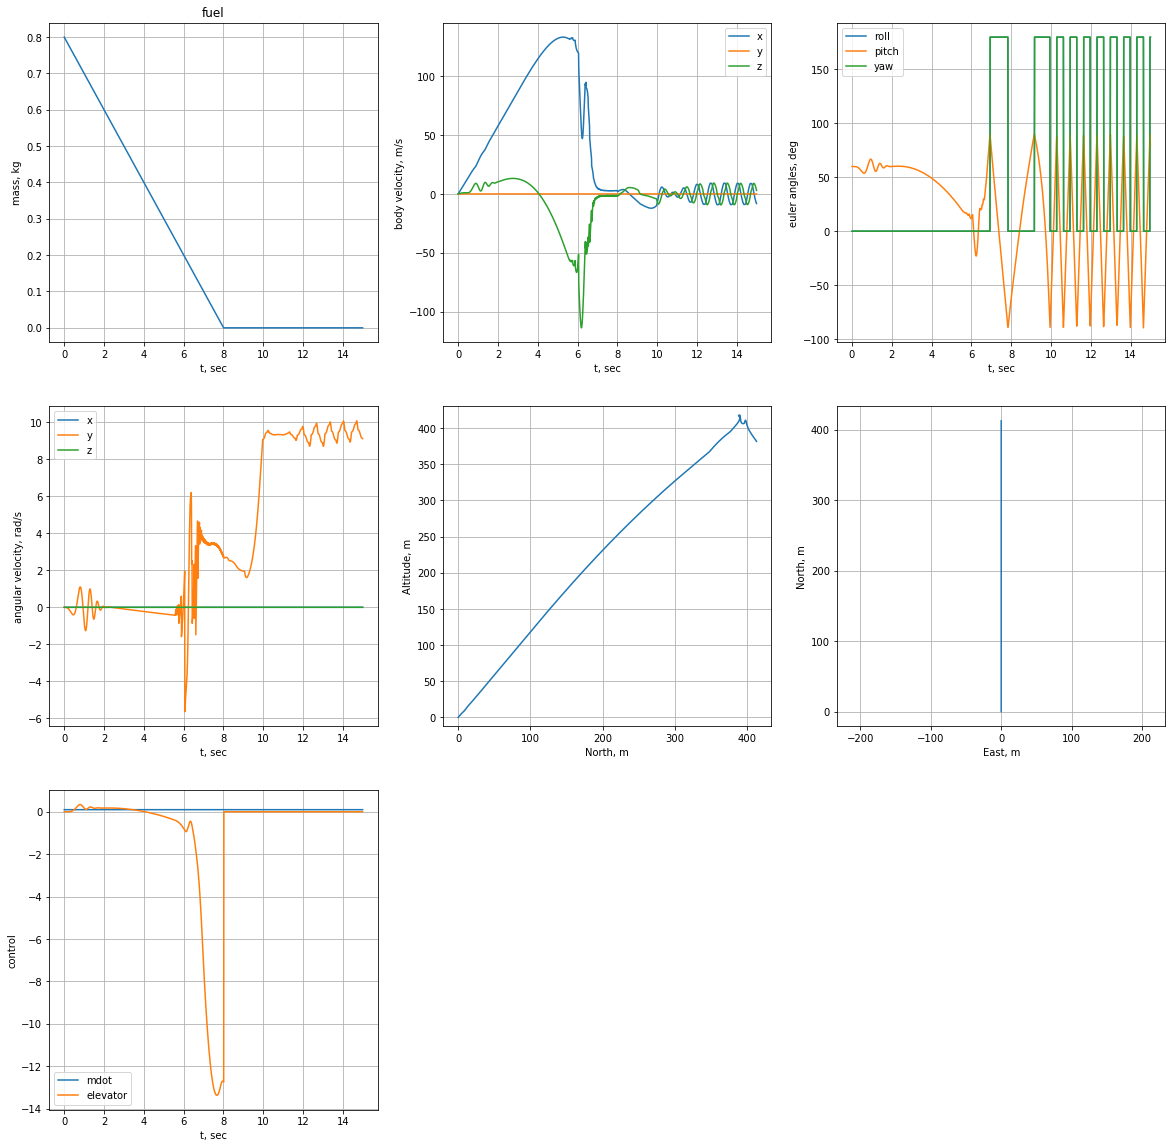

In [112]:
run()